In [123]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()  # noqa
import dash_bio as dashbio
from python.cogtext.datasets.pubmed import PubMedDataLoader
from python.cogtext.similarity_matrix import get_similarity_matrix

In [124]:
# load weights, clusters and metadata (takes <20sec)

clusters = pd.read_csv('models/cogtext/abstracts_clusters.csv.gz', index_col=0)
weights = np.load('models/cogtext/abstracts_weights.npz')['arr_0']
clusters['weights'] = list(weights)

pubmed = PubMedDataLoader(preprocessed=False, drop_low_occurred_labels=True).load()
pubmed = pubmed.merge(clusters, on='pmid', how='left')

pubmed.dropna(subset=['cluster'], inplace=True)

## Multivariate Normal KL Divergence

In [125]:
from sklearn.preprocessing import StandardScaler
from python.cogtext.similarity_matrix import multivariate_normal_kl
from tqdm import tqdm

x = pubmed.groupby('label')['weights'].apply(np.stack)

kl_dists = np.zeros((x.index.shape[0], x.index.shape[0]))
for i,wi in enumerate(x):
  for j,wj in enumerate(x):
    if i == j: continue
    kl_dists[i,j] = multivariate_normal_kl(wi, wj)

kl_dists_df = pd.DataFrame(kl_dists, index=x.index, columns=x.index)
kl_dists_df.replace([np.inf, -np.inf], np.nan, inplace=True)
kl_dists_df.replace([np.nan], 0, inplace=True)

kl_dists_norm = StandardScaler().fit_transform(kl_dists_df)
kl_dists_df = pd.DataFrame(kl_dists_norm, index=x.index, columns=x.index)

# drop tasks for visualization
tasks = pubmed.query('category.str.contains("Task")')['label'].unique()
kl_dists_df.drop(index=tasks, columns=tasks, inplace=True)

In [156]:
# sns.clustermap(kl_dists_df,
#                dendrogram_ratio=0.0001,
#                cbar_pos=(1.0, .75, 0.03, 0.2),
#                cmap='RdBu_r', figsize=(35,35))
# plt.show()


dashbio.Clustergram(
  data=kl_dists_df,
  column_labels=kl_dists_df.columns.to_list(),
  row_labels=kl_dists_df.index.to_list(),
  cluster='all',
  center_values=False,
  height=800,
  width=1000,
  display_ratio=[0.001, 0.001],
  color_map='RdBu_r',
  hidden_labels=['col'],
  row_dist='euclidean',
  col_dist='euclidean',
  # standardize='col'
)

## Categorical KL Divergence

In [127]:
# plot label-label similarity matrix

# mean-pooling: create label-embeddings by averaging doc-embeddings of each label
# label_embeddings = pubmed.groupby('label')['weights'].apply(np.mean)

# max-pooling
label_embeddings = (
  pubmed.groupby('label')['weights'].apply(lambda x: np.max(np.stack(x.values), axis=0))
)

label_embeddings = pd.DataFrame(np.stack(label_embeddings), index=label_embeddings.index)

def find_category_by_label(label, pubmed=pubmed):
  return pubmed.query('label == @label')['category'].iloc[0]

# add categories of labels
label_embeddings['category'] = label_embeddings.index.to_series().apply(find_category_by_label)
label_embeddings.set_index(['category'], append=True, inplace=True)

In [128]:
# # now generate the task-construct similarity matrix
labels_kl = get_similarity_matrix(label_embeddings, metric='kl', pivot_by_category=False)


# # drop tasks for visualization
tasks = pubmed.query('category.str.contains("Task")')['label'].unique()
labels_kl.drop(index=tasks, columns=tasks, inplace=True)

# # heatmap plot categorized by label category, either task or construct
# g = sns.clustermap(labels_sim,
#                    figsize=(25, 25),
#                    dendrogram_ratio=0.0001, 
#                    cbar_pos=(1.0, 0.73, 0.03, 0.25),
#                    robust=True)
# plt.show()

dashbio.Clustergram(
  data=labels_kl,
  column_labels=labels_kl.columns.to_list(),
  row_labels=labels_kl.index.to_list(),
  cluster='all',
  center_values=False,
  height=800,
  width=1000,
  display_ratio=[0.001, 0.001],
  color_map='RdBu_r',
  hidden_labels=['col'],
  row_dist='euclidean',
  col_dist='euclidean',
  # standardize='col'
)


## Popular Constructs

In [129]:
# plot only popular tasks and popular constructs

n_popular_labels = 40

popular_labels = (pubmed.groupby(['category','label'])['pmid']
                        .count().sort_values(ascending=False)
                        .groupby('category').head(n_popular_labels)
                        .index.get_level_values('label').to_list())

popular_label_embeddings = label_embeddings.query('label in @popular_labels')

popular_labels_kl = get_similarity_matrix(
  popular_label_embeddings,
  metric='kl',
  pivot_by_category=False)

# # drop tasks for visualization
tasks = pubmed.query('category.str.contains("Task")')['label'].unique()
popular_labels_kl.drop(index=tasks, columns=tasks, errors='ignore', inplace=True)

# g = sns.clustermap(popular_labels_sim, robust=True,
#                    dendrogram_ratio=0.0001, 
#                    cbar_pos=(1.0, 0.73, 0.03, 0.25),
#                    cmap='viridis_r',
#                   )
# plt.show()

import dash_bio as dashbio

dashbio.Clustergram(
  data=popular_labels_kl,
  column_labels=popular_labels_kl.columns.to_list(),
  row_labels=popular_labels_kl.index.to_list(),
  center_values=False,
  cluster='all',
  height=800,
  width=900,
  display_ratio=[0.001, 0.001], 
  color_map='RdBu_r',
  # hidden_labels=['col'],
  row_dist='euclidean',
  col_dist='euclidean',
  # standardize='col'
)

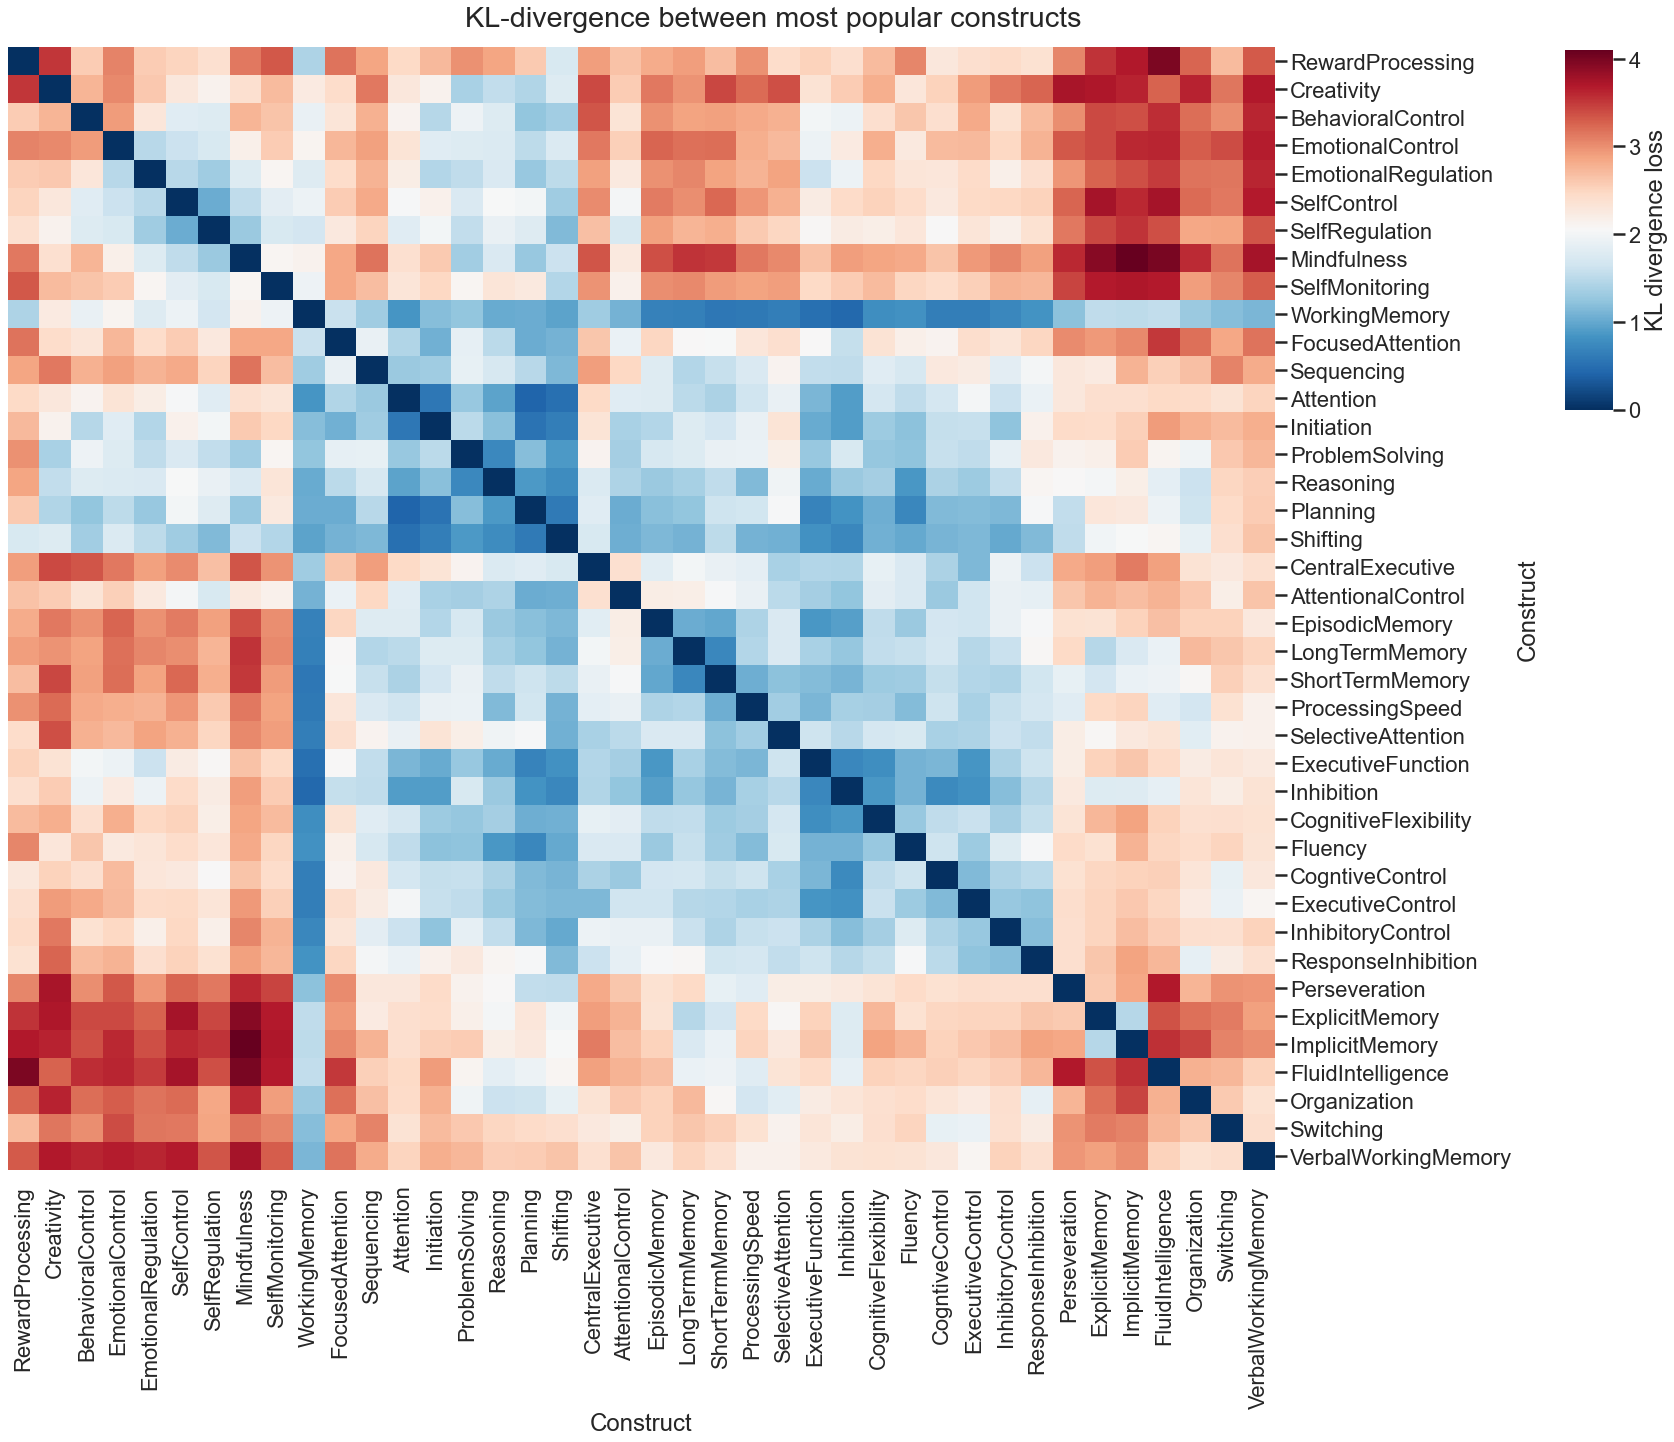

In [130]:
# plot kl-divergence between construct labels, ignoring the task labels.

X = popular_label_embeddings.query('category.str.contains("Construct")')
X_sim = get_similarity_matrix(X, metric='kl', pivot_by_category=False)

sns.set('poster')
g = sns.clustermap(X_sim,figsize=(22,20), dendrogram_ratio=0.0001,
               cbar_pos=(1.0, 0.73, 0.03, 0.25),
               cmap='RdBu_r', cbar_kws={'label': 'KL divergence loss'})
g.ax_heatmap.set(xlabel='Construct', ylabel='Construct')
plt.suptitle('KL-divergence between most popular constructs',y=1.01)
plt.show()

In [131]:
# create a graph

import stellargraph as sg
from stellargraph.data import UniformRandomMetaPathWalk

embeddings = popular_label_embeddings

sim = get_similarity_matrix(embeddings, metric='kl', pivot_by_category=False)
sim.columns.name = 'source'
sim.index.name = 'target'

# keep = np.triu(np.ones(sim.shape)).astype('bool').reshape(sim.size)
adj = sim.stack().to_frame().reset_index()
adj = adj.query('target != source').rename(columns={0:'weight'})

edges = adj
# sim = 1/kl
edges['weight'] = edges['weight'].apply(lambda x: 1./x)
edges = edges.query('weight > weight.mean()')

constructs = label_embeddings.query('category == "CognitiveConstruct"').reset_index(1,drop=True)
tasks = label_embeddings.query('category == "CognitiveTask"').reset_index(1,drop=True)

G = sg.StellarGraph(
  nodes = {'task': tasks,
           'construct': constructs},
  edges=edges)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 168, Edges: 1998

 Node types:
  task: [96]
    Features: float32 vector, length 629
    Edge types: task-default->construct, task-default->task
  construct: [72]
    Features: float32 vector, length 629
    Edge types: construct-default->construct, construct-default->task

 Edge types:
    construct-default->construct: [988]
        Weights: range=[0.408945, 2.43925], mean=0.668922, std=0.294799
        Features: none
    construct-default->task: [812]
        Weights: range=[0.408576, 1.9462], mean=0.543326, std=0.175973
        Features: none
    task-default->task: [198]
        Weights: range=[0.408898, 8.4057], mean=0.643303, std=0.805247
        Features: none


In [132]:
# metapath2vec

from gensim.models import Word2Vec

# metapath schemas as a list of lists of node types.
metapaths = [
    ['task', 'construct', 'task'],
    ['construct', 'task', 'construct'],
    # ['construct', 'task', 'task', 'construct'],
    # ['task', 'construct', 'task', 'construct', 'task'],
    # ['task', 'construct', 'construct', 'task'],
]

walks = UniformRandomMetaPathWalk(G).run(
    nodes=list(G.nodes()),  # root nodes
    length=3,  # maximum length of a random walk
    n=5,  # number of random walks per root node
    metapaths=metapaths,  # the metapaths
)

print(f'Number of random walks: {len(walks)}')
print('Random walks starting from the "RewardProcessing" node:',
      [' -> '.join(w) for w in walks if w[0] == 'RewardProcessing'])

model = Word2Vec(walks, vector_size=128, min_count=0, window=3, sg=1, workers=1, epochs=1000)

model.save('models/cogtext/abstracts_metapath2vec.pkl')

Number of random walks: 840
Random walks starting from the "RewardProcessing" node: ['RewardProcessing -> Delay_Discounting_task -> Attention', 'RewardProcessing -> Delay_Discounting_task -> Attention', 'RewardProcessing -> ReversalLearning -> Inhibition', 'RewardProcessing -> Go_NoGo -> LongTermMemory', 'RewardProcessing -> DiscountingTask -> Attention']


In [133]:
# query the joint graph

model.wv.most_similar(
  positive=['RewardProcessing'],
  # negative=['TMT_-_Trail_Making_Task']
  topn=10)

[('SelfControl', 0.6663165092468262),
 ('SelfMonitoring', 0.6266443133354187),
 ('DiscountingTask', 0.606277585029602),
 ('Delay_Discounting_task', 0.6010947227478027),
 ('Mindfulness', 0.6008867621421814),
 ('EmotionalControl', 0.5719100832939148),
 ('Keep_Track_task', 0.5459797382354736),
 ('SimpleRT', 0.5424729585647583),
 ('SelfRegulation', 0.5405811071395874),
 ('ReversalLearning', 0.536972165107727)]

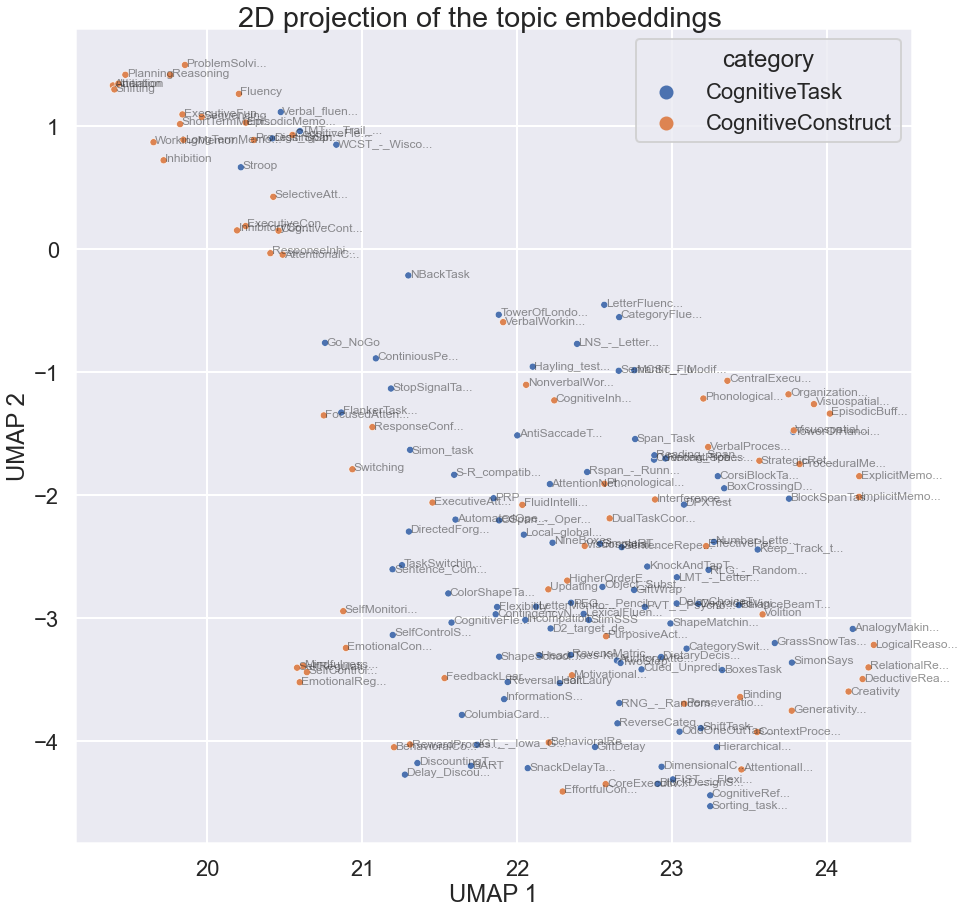

In [171]:
import plotly.express as px

# projections = PCA(n_components=2, random_state=0).fit_transform(label_embeddings)
projections_3d = UMAP(n_components=3, random_state=0).fit_transform(popular_label_embeddings)
projections_2d = UMAP(n_components=2, random_state=0).fit_transform(label_embeddings)

projections_3d = pd.DataFrame(projections_3d, index=popular_label_embeddings.index).reset_index()
projections_2d = pd.DataFrame(projections_2d, index=label_embeddings.index).reset_index()

fig = px.scatter_3d(projections_3d,
                    x=0, y=1, z=2,
                    color='category', hover_name='label',
                    title='Popular labels in the topic space',
                    color_discrete_sequence=['red','blue'],
                    width=600, height=600,)
fig.show()


fig, ax = plt.subplots(1,1, figsize=(15,15))
sns.scatterplot(data=projections_2d, x=0, y=1, ax=ax, s=50, hue='category')

for (i,lbl, _,x, y) in projections_2d.itertuples():
  lbl = f'{lbl[:12]}...' if len(lbl)>10 else lbl
  ax.text(x+0.01, y-np.random.random()*.02, f'{lbl}', alpha=0.5, fontsize=12)

ax.set(xlabel='UMAP 1', ylabel='UMAP 2')
plt.suptitle('2D projection of the topic embeddings',y=.9)
plt.show()

In [172]:
%reload_ext watermark
%watermark
%watermark -iv -p umap,pytorch,scikit-learn,python.cogtext

Last updated: 2021-12-08T09:06:51.606879+01:00

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.28.0

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.1.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit

umap          : 0.5.2
pytorch       : not installed
scikit-learn  : 0.0
python.cogtext: 0.1.2021120807

numpy       : 1.20.3
ipykernel   : 6.4.1
sys         : 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:23:19) 
[Clang 11.1.0 ]
seaborn     : 0.11.2
plotly      : 5.3.1
matplotlib  : 3.4.3
debugpy     : 1.4.1
pandas      : 1.3.4
stellargraph: 1.2.1
dash_bio    : 0.8.0

